In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import selective_search

import cv2

import xml.etree.ElementTree as ET
from PIL import Image
import os

In [2]:
import gc
gc.collect()
torch.mps.empty_cache()

In [3]:
AlexNet = models.alexnet(weights="IMAGENET1K_V1", progress=True)
AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Custom Dataset

In [4]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

In [5]:
def parse_xml_boxes(root):
    bboxes = []
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        if cls_name in VOC_CLASSES:
            cls_idx = VOC_CLASSES.index(cls_name)
            xmin = int(obj.find('bndbox').find('xmin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax, cls_idx])

    return bboxes

def draw_gtbboxes(img_path, anno_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    tree = ET.parse(anno_path)
    root = tree.getroot()
    gt_bboxes = parse_xml_boxes(root)

    # Draw bounding boxes
    for bbox in gt_bboxes:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)

    return image

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, img_set='trainval', num_classes=20):
        self.root = root
        self.transform = transform
        self.img_set = img_set
        self.num_classes = num_classes
        
        self.annotation_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'Annotations')
        self.img_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'JPEGimages')

        self.annotations = [os.path.join(self.annotation_path, xml) for xml in sorted(os.listdir(self.annotation_path)) if not xml.startswith('.')]
        self.images = [os.path.join(self.img_path, xml) for xml in sorted(os.listdir(self.img_path)) if not xml.startswith('.')]
        self.annotations = self.annotations[:500]
        self.images = self.images[:500]
    
    def __len__(self):
        return len(self.images)

        
    def apply_ss(self, img_path):
        bboxes = selective_search.selective_search(img_path)
        bboxes = torch.stack([torch.tensor(bbox) for bbox in bboxes])
        return bboxes

    
    def compute_iou(self, boxA, boxB):
        # Compute the Intersection over Union (IoU) between two bounding boxes
        xA = max(boxA[0], boxB[0])  # max of xmin
        yA = max(boxA[1], boxB[1])  # max of ymin
        xB = min(boxA[2], boxB[2])  # min of xmax
        yB = min(boxA[3], boxB[3])  # min of ymax
    
        # Compute the area of the intersection rectangle
        interWidth = max(0, xB - xA + 1)
        interHeight = max(0, yB - yA + 1)
        interArea = interWidth * interHeight
    
        # Compute the area of both bounding boxes
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
        # Compute the Intersection over Union by dividing the intersection area by the sum of both areas minus the intersection
        iou = interArea / float(boxAArea + boxBArea - interArea) if interArea > 0 else 0.0
    
        return iou

    
    def sample_proposals(self, proposals, gt_boxes, gt_labels):
        iou_threshold = 0.5
        positive_proposals = []
        positive_labels = []
        negative_proposals = []

        for proposal in proposals:
            max_iou = 0
            best_label = None

            for gt_box, label in zip(gt_boxes, gt_labels):
                iou = self.compute_iou(proposal, gt_box)
                # To prevent multiple objects being positive to one bounding box, choose the best one
                if iou > max_iou:
                    max_iou = iou
                    best_label = label
            # If iou of any gt_box is greater than the threshold, it is positive proposal
            if max_iou >= iou_threshold:
                positive_proposals.append(proposal)
                positive_labels.append(best_label) # use the best label
            # Else, negative proposal
            else:
                negative_proposals.append(proposal)

        # Choose 32 positives and 96 negatives
        num_positive = min(32, len(positive_proposals))
        num_negative = min(96, len(negative_proposals))
        selected_positives = positive_proposals[:num_positive]
        selected_negatives = negative_proposals[:num_negative]
        selected_labels = positive_labels[:num_positive]
        selected_labels.extend([21] * num_negative) # Background class label as 21

        sampled_proposals = torch.stack(selected_positives + selected_negatives)
        sampled_labels = torch.tensor(selected_labels, dtype=torch.int64)
        return sampled_proposals, sampled_labels

    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        annotation_path = self.annotations[idx]

        image = Image.open(image_path).convert('RGB')

        tree = ET.parse(annotation_path)
        root = tree.getroot()
        gt_bboxes_labels = torch.tensor(parse_xml_boxes(root))

        # Apply selective search to get the tensor of region proposals: Tesor([~2000, 4])
        proposals = self.apply_ss(image_path)
        # Sample out ~32 positives + 96 negatives
        sampled_proposals, sampled_labels = self.sample_proposals(proposals, gt_bboxes_labels[:, :4], gt_bboxes_labels[:, -1])
        
        target = {"boxes": sampled_proposals, "labels": sampled_labels}

        return image, target
            
            

In [7]:
#listof (image, target) -> (listof(image), listof(target))
def collate_fn(batch):
    #return tuple(zip(*batch))
    return zip(*batch)

In [8]:
root = '/Users/h383kim/pytorch/data'
train_dataset = CustomDataset(root, None, 'trainval', 20)
test_dataset = CustomDataset(root, None, 'test', 20)
print(len(train_dataset))
print(len(test_dataset))

500
500


# Print to see if the Custom Dataset works well

Image:


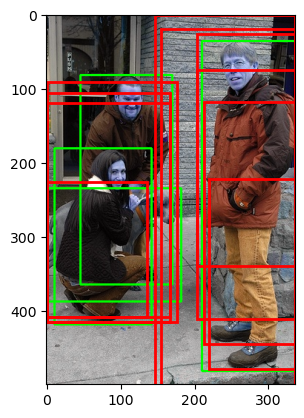

In [10]:
print(f"Image:")
#print(f"Image Shape: {train_dataset[8][0].shape}")

sample_img_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/JPEGimages/000021.jpg'
sample_anno_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000021.xml'
sample_w_boxes = draw_gtbboxes(sample_img_path, sample_anno_path)

bboxes = train_dataset[8][1]["boxes"]
# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(sample_w_boxes)

# Draw bounding boxes
for bbox in bboxes[:10]:
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# x_min, y_min, width, height = 196, 165, 489 - 196, 247 - 165
# rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
# ax.add_patch(rect)

In [11]:
print(train_dataset[8][1]["boxes"])
print(train_dataset[8][1]["labels"])

tensor([[147,   0, 336, 500],
        [213, 121, 316, 445],
        [127,   0, 336, 500],
        [209, 112, 336, 500],
        [169,  19, 336, 434],
        [129,  19, 336, 427],
        [200,  76, 336, 421],
        [  0, 252, 213, 428],
        [  0, 226, 136, 408],
        [213, 121, 316, 443],
        [  0, 106, 167, 417],
        [204,  77, 336, 427],
        [203,  26, 336, 339],
        [203,  74, 336, 411],
        [213, 118, 336, 445],
        [  0, 120, 167, 408],
        [214, 222, 336, 500],
        [204,  74, 336, 435],
        [ 14, 287, 202, 384],
        [  0,   0, 136, 423],
        [  0, 136, 132, 407],
        [  0,  91, 176, 415],
        [  0,  99, 176, 410],
        [  0, 232, 114, 368],
        [  0,   0, 141, 432],
        [209,  75, 336, 335],
        [211,   0, 336, 496],
        [ 73, 123, 167, 342],
        [  0, 182, 154, 413],
        [  0, 122, 167, 408],
        [154,  19, 336, 500],
        [  0, 235, 114, 361],
        [279, 176, 305, 205],
        [ 

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=collate_fn)

In [13]:
from torchvision.transforms import v2
import torchvision.transforms as T

VOC_VAL = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

def convert_to_pil(image):
    if isinstance(image, torch.Tensor):
        return T.ToPILImage()(image)  # Convert tensor back to PIL image
    return image

img_transform = T.Compose([
    T.Resize((227, 227)),
    convert_to_pil,  # Ensure the image is a PIL Image
    T.ToTensor(),
    T.Normalize(mean=VOC_VAL[0], std=VOC_VAL[1])
])

In [14]:
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop

def transform_proposal(cropped_img):
    # Ensure the image is in [C, H, W] format
    if len(cropped_img.shape) == 2:  # If the image is [H, W], add a channel dimension
        cropped_img = cropped_img.unsqueeze(0)
    
    # Convert tensor to PIL Image for transformations
    pil_img = transforms.ToPILImage()(cropped_img)

    # Convert grayscale (single-channel) images to RGB
    if pil_img.mode != 'RGB':
        pil_img = pil_img.convert("RGB")
    
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Resize to 227x227
        transforms.ToTensor(),  # Convert back to tensor
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    return transform(pil_img)


def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into train mode
    model.train()
    train_loss, correct, train_acc = 0, 0, 0
    total_proposals = 0
    
    for images, targets in dataloader:
        images = torchvision.transforms.functional.pil_to_tensor(images[0]).to(DEVICE)
        #print(targets)
        targets = [{k: v.to(DEVICE) for k, v in targets[0].items()}]
        #print(targets.type)

        for img, target in zip(images, targets):
            proposals = target["boxes"] #Tensor([128, 4])
            labels = target["labels"] # Tensor([128])
            # List to store the transformed proposals
            transformed_proposals = []
            
            # Loop over each bounding box proposal
            for i, proposal in enumerate(proposals):
                # Extract the bounding box coordinates
                x_min, y_min, x_max, y_max = proposal
            
                # Crop the image using torchvision's functional crop method
                cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max - y_min).item(), width=(x_max - x_min).item())
            
                # Resize and apply other transformations
                resized_img = transform_proposal(cropped_img)
            
                # Append the transformed image to the list
                transformed_proposals.append(resized_img)
            
            # Stack all the transformed proposals into a batch (shape [~128, 3, 227, 227])
            batch_of_proposals = torch.stack(transformed_proposals)
            batch_of_proposals = batch_of_proposals.to(DEVICE)
            total_proposals += batch_of_proposals.shape[0]
            
            # Now, batch_of_proposals is ready to be fed into AlexNet
            #print(batch_of_proposals.shape)  # Should output: torch.Size([128, 3, 227, 227])
            
            # forward pass
            pred_probs = model(batch_of_proposals)

            # Calculate the loss
            loss = loss_fn(pred_probs, labels)
            train_loss += loss.item()

            # Optimizer zero_grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            #optimizer step
            optimizer.step()

            pred = torch.argmax(pred_probs, dim=1)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    train_loss /= len(dataloader) # (Sum of train_loss for each batch) / (# of batches)
    train_acc = 100. * correct / total_proposals
    print(f"Number of proposals seen: {total_proposals}")
    return train_loss, train_acc

In [15]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

NUM_CLASSES = 21
num_features = AlexNet.classifier[6].in_features
AlexNet.classifier[6] = nn.Linear(in_features=num_features, out_features=NUM_CLASSES)
AlexNet.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(AlexNet.parameters(), lr=0.001, momentum=0.9)

In [16]:
import time
import copy

def fine_tune(model: torch.nn.Module, 
              train_dataloader: torch.utils.data.DataLoader, 
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
              num_epochs: int=10):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        # Train the model and print save the results
        train_loss, train_acc = train(model=model,
                                      dataloader=train_dataloader, 
                                      optimizer=optimizer,
                                      loss_fn=loss_fn)
        
        if train_acc > best_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        end_time = time.time()
        time_elapsed = end_time - start_time
        print(f"------------ epoch {epoch} ------------")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
        print(f"Time taken: {time_elapsed / 60:.0f}min {time_elapsed % 60:.0f}s")
        
    model.load_state_dict(best_model_wts)
    return model 

In [21]:
Fined_tuned = fine_tune(AlexNet, train_loader, optimizer, loss_fn)

Number of proposals seen: 63759
------------ epoch 1 ------------
Train loss: 0.5669 | Train acc: 8.03%
Time taken: 28min 31s
Number of proposals seen: 63759
------------ epoch 2 ------------
Train loss: 0.4021 | Train acc: 12.44%
Time taken: 28min 43s
Number of proposals seen: 63759
------------ epoch 3 ------------
Train loss: 0.3182 | Train acc: 14.79%
Time taken: 28min 41s
Number of proposals seen: 63759
------------ epoch 4 ------------
Train loss: 0.2480 | Train acc: 17.17%
Time taken: 28min 42s
Number of proposals seen: 63759
------------ epoch 5 ------------
Train loss: 0.2043 | Train acc: 18.36%
Time taken: 28min 39s
Number of proposals seen: 63759
------------ epoch 6 ------------
Train loss: 0.1674 | Train acc: 19.53%
Time taken: 28min 45s
Number of proposals seen: 63759
------------ epoch 7 ------------
Train loss: 0.1369 | Train acc: 20.52%
Time taken: 28min 45s
Number of proposals seen: 63759
------------ epoch 8 ------------
Train loss: 0.1158 | Train acc: 21.21%
Time ta

In [22]:
# torch.save(Fined_tuned.state_dict(), 'Alex_tuned.pth')

In [17]:
Alex_tuned = models.alexnet(weights="IMAGENET1K_V1", progress=True)
Alex_tuned.classifier[6] = nn.Linear(4096, 21)
Alex_tuned.load_state_dict(torch.load('Alex_tuned.pth'))

<All keys matched successfully>

In [18]:
class Feature_Extractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # Remove the final classification layer (4096 - 21 layer)
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten the features
        x = self.classifier(x)
        
        return x

In [19]:
feature_extractor = Feature_Extractor(Alex_tuned).to(DEVICE)

In [20]:
feature_extractor

Feature_Extractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bi

In [21]:
import random
from tqdm import tqdm

IMG_PATH = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/JPEGImages'
ANNO_PATH = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations'

def compute_iou(boxA, boxB):
        # Compute the Intersection over Union (IoU) between two bounding boxes
        xA = max(boxA[0], boxB[0])  # max of xmin
        yA = max(boxA[1], boxB[1])  # max of ymin
        xB = min(boxA[2], boxB[2])  # min of xmax
        yB = min(boxA[3], boxB[3])  # min of ymax
    
        # Compute the area of the intersection rectangle
        interWidth = max(0, xB - xA + 1)
        interHeight = max(0, yB - yA + 1)
        interArea = interWidth * interHeight
    
        # Compute the area of both bounding boxes
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
        # Compute the Intersection over Union by dividing the intersection area by the sum of both areas minus the intersection
        iou = interArea / float(boxAArea + boxBArea - interArea) if interArea > 0 else 0.0
    
        return iou

def sample_negatives(proposals, gt_boxes, gt_labels, num_samples):
    iou_threshold = 0.3
    negative_proposals = []
    
    random_indices = random.sample(range(len(proposals)), len(proposals))    

    for i in random_indices:
        proposal = proposals[i]
        # Only consider if IoU <= 0.3 for all gt_boxes
        is_negative = True
        for gt_box in gt_boxes:
            iou = compute_iou(proposal, gt_box)
            if iou > 0.3:
                is_negative = False
                break

        if is_negative:
            negative_proposals.append(proposal)

        # Three sampled
        if len(negative_proposals) == num_samples:
            break
            
    return negative_proposals

def transform_proposal_SVM(cropped_img):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Resize to 227x227
        transforms.ToTensor(),  # Convert back to tensor
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    return transform(cropped_img)

def extract(img_path, anno_path, iou_threshold=0.3):
    """
    Returns positive and negative samples based on IoU threshold.
    Ground Truth Boxes -> Postive Samples
    Proposals <= iou_threshold -> Negative Samples
    """
    positive_features = []
    positive_labels = []
    negative_features = []
    negative_labels = []

    img_list = [os.path.join(img_path, file) for file in sorted(os.listdir(img_path)) if not file.startswith('.')]
    anno_list = [os.path.join(anno_path, file) for file in sorted(os.listdir(anno_path)) if not file.startswith('.')]
    
    for i in tqdm(range(len(img_list)), desc='processing image'):
        img = Image.open(img_list[i])
        tree = ET.parse(anno_list[i])
        root = tree.getroot()
        gt_bboxes_labels = torch.tensor(parse_xml_boxes(root))
        gt_bboxes, gt_labels = gt_bboxes_labels[:, :4], gt_bboxes_labels[:, -1]

        # Positive sampling and extracting features
        with torch.no_grad():
            for j in range(len(gt_bboxes_labels)):
                x_min, y_min, x_max, y_max = gt_bboxes[j]  
                cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max - y_min).item(), width=(x_max - x_min).item())
                transformed_img = transform_proposal_SVM(cropped_img).to(DEVICE).unsqueeze(0)
                # Feed forward to CNN
                feature_vector = feature_extractor(transformed_img).squeeze(0).cpu().numpy()
                positive_features.append(feature_vector)
                positive_labels.append(gt_labels[j].item())

        # Negative sampling and extracting features
        NUM_SAMPLES = 3
        bboxes = selective_search.selective_search(img_list[i])
        bboxes = torch.stack([torch.tensor(bbox) for bbox in bboxes])
        negative_proposals = sample_negatives(bboxes, gt_bboxes, gt_labels, NUM_SAMPLES) # Sample 3 negatives

        with torch.no_grad():
            for j in range(NUM_SAMPLES):
                x_min, y_min, x_max, y_max = negative_proposals[j]
                cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max - y_min).item(), width=(x_max - x_min).item())
                transformed_img = transform_proposal_SVM(cropped_img).to(DEVICE).unsqueeze(0)
                # Feed forward to CNN
                feature_vector = feature_extractor(transformed_img).squeeze(0).cpu().numpy()
                negative_features.append(feature_vector)
                negative_labels.append(21)

    return positive_features + negative_features, positive_labels + negative_labels

In [147]:
Features, Labels = extract(IMG_PATH, ANNO_PATH)

processing image: 100%|███████████████████| 5011/5011 [3:12:47<00:00,  2.31s/it]


In [150]:
# import pickle

# with open('svm_train_features.pkl', 'wb') as f:
#     pickle.dump(Features, f)
# with open('svm_train_labels.pkl', 'wb') as f:
#     pickle.dump(Labels, f)

In [22]:
import pickle
with open('svm_train_features.pkl', 'rb') as f:
    Features = pickle.load(f)
with open('svm_train_labels.pkl', 'rb') as f:
    Labels = pickle.load(f)

In [24]:
import numpy as np
from sklearn.svm import SVC

#Training SVMs
svm_classifiers = {}
for class_id in tqdm(range(20), desc="Training SVMs:"):
    Labels = np.array(Labels)
    OvR_labels = (Labels[:15000] == class_id).astype(int)
    svm_classifier = SVC(kernel='linear', C=1.0, probability=False)
    svm_classifier.fit(Features[:15000], OvR_labels)
    svm_classifiers[class_id] = svm_classifier

Training SVMs:: 100%|███████████████████████████| 20/20 [05:07<00:00, 15.36s/it]


In [25]:
with open('trained_svm.pkl', 'wb') as f:
    pickle.dump(svm_classifiers, f)

In [26]:
def predict_svm(svm_classifiers, test_features): 
    scores=[]
    for class_id, svm_classifier in svm_classifiers.items():
        class_score = svm_classifier.decision_function(test_features)
        scores.append(class_score)

    scores = np.array(scores)
    predicted_labels = np.argmax(scores, axis=0)
    return predicted_labels, scores

def interpret(labels):
    return [VOC_CLASSES[i] for i in labels]

# Make sure SVM is trained well

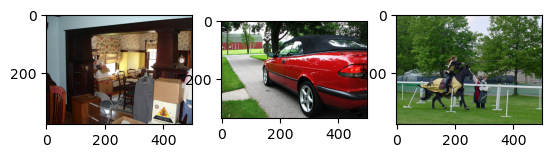

['chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'car',
 'horse',
 'person',
 'person',
 'person']

In [27]:
IMG_LIST = [os.path.join(IMG_PATH, file) for file in sorted(os.listdir(IMG_PATH)) if not file.startswith('.')]
ANNO_LIST = [os.path.join(ANNO_PATH, file) for file in sorted(os.listdir(ANNO_PATH)) if not file.startswith('.')]

fig, axes = plt.subplots(1, 3)
for i in range(3):
    img = plt.imread(IMG_LIST[i])
    axes[i].imshow(img)
plt.show()

"""
Rember svm_classifier.decision_function() Takes in 2d array.
Thus, when you input one image, you should make sure to resize it into 2d
i.e features.reshape(1, -1)
""" 
#predict_svm(svm_classifiers, Features[0].reshape(1, 4096))
#predict_svm(svm_classifiers, Features[0:2])[1]
interpret(predict_svm(svm_classifiers, Features[0:10])[0])

# Bounding-Box Regressors

In [28]:
class BBoxRegressor(nn.Module):
    def __init__(self, num_classes=20, in_channels=4096):
        super().__init__()

        self.regressors = nn.ModuleDict({str(cls) : nn.Linear(in_features=in_channels, out_features=4) for cls in range(20)})

    def forward(self, x, cls_ids):
        # x is the feature tensor of shape [batch_size, 4096]
        # cls_ids is a tensor of shape [batch_size], where each element is the class ID
        outputs = []
        for i in range(x.size(0)):
            cls_id = cls_ids[i].item()
            outputs.append(self.regressors[str(cls_id)](x[i]))
        return torch.stack(outputs)

In [29]:
class RidgeRegressionLoss(nn.Module):
    def __init__(self, lambda_reg=1):
        super().__init__()
        self.lambda_reg = lambda_reg
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets, model):
        # MSE loss between predictions and ground truth targets
        mse = self.mse(predictions, targets)
        
        # L2 regularization (ridge regression)
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)

        # Combine MSE loss with L2 regularization
        loss = mse + self.lambda_reg * l2_reg

        return loss

In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, img_set='trainval', num_classes=20):
        self.root = root
        self.transform = transform
        self.img_set = img_set
        self.num_classes = num_classes
        
        self.annotation_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'Annotations')
        self.img_path = os.path.join(self.root, f'PASCAL_VOC_{self.img_set}', 'VOCdevkit', 'VOC2007', 'JPEGimages')

        self.annotations = [os.path.join(self.annotation_path, xml) for xml in sorted(os.listdir(self.annotation_path)) if not xml.startswith('.')]
        self.images = [os.path.join(self.img_path, xml) for xml in sorted(os.listdir(self.img_path)) if not xml.startswith('.')]
        self.annotations = self.annotations[:200]
        self.images = self.images[:200]
    
    def __len__(self):
        return len(self.images)

        
    def apply_ss(self, img_path):
        bboxes = selective_search.selective_search(img_path)
        bboxes = torch.stack([torch.tensor(bbox) for bbox in bboxes])
        return bboxes

    
    def compute_iou(self, boxA, boxB):
        # Compute the Intersection over Union (IoU) between two bounding boxes
        xA = max(boxA[0], boxB[0])  # max of xmin
        yA = max(boxA[1], boxB[1])  # max of ymin
        xB = min(boxA[2], boxB[2])  # min of xmax
        yB = min(boxA[3], boxB[3])  # min of ymax
    
        # Compute the area of the intersection rectangle
        interWidth = max(0, xB - xA + 1)
        interHeight = max(0, yB - yA + 1)
        interArea = interWidth * interHeight
    
        # Compute the area of both bounding boxes
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
        # Compute the Intersection over Union by dividing the intersection area by the sum of both areas minus the intersection
        iou = interArea / float(boxAArea + boxBArea - interArea) if interArea > 0 else 0.0
    
        return iou

    
    def sample_proposals(self, proposals, gt_boxes, gt_labels):
        iou_threshold = 0.6
        class_proposals = {}
        final_proposals = []
        final_labels = []
        final_gtbox = []
        
        for gt_box, label in zip(gt_boxes, gt_labels):
            max_iou = 0
            best_box = None

            for proposal in proposals:
                iou = self.compute_iou(proposal, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    best_box = proposal

            if max_iou >= iou_threshold:
                class_proposals[(label, gt_box)] = best_box, max_iou

        for (cls, gt_box), (best_box, iou) in class_proposals.items():
            final_proposals.append(best_box)
            final_labels.append(cls)
            final_gtbox.append(gt_box)

        return final_proposals, final_labels, final_gtbox

    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        annotation_path = self.annotations[idx]

        image = Image.open(image_path).convert('RGB')

        tree = ET.parse(annotation_path)
        root = tree.getroot()
        gt_bboxes_labels = torch.tensor(parse_xml_boxes(root))

        # Apply selective search to get the tensor of region proposals: Tesor([~2000, 4])
        proposals = self.apply_ss(image_path)
        # Sample the single best box for each ground truth boxes in the image (iou >= 0.6)
        sampled_proposals, sampled_labels, gtboxes = self.sample_proposals(proposals, gt_bboxes_labels[:, :4], gt_bboxes_labels[:, -1])
        """
            target will have maximum of (# of gtboxes)-samples in the image. 
            It could be less if NO proposals have iou greater than 0.6 to some gtbox.
            For example in the test below, even though there are 5 ground truth boxes, only 4 will be sampled as iou > 0.6 DNE for one.
        """
        target = {"boxes": sampled_proposals, "labels": sampled_labels, "gtboxes": gtboxes}

        return image, target
            
            

In [31]:
def transform_proposal(cropped_img):
    # Ensure the image is in [C, H, W] format
    if len(cropped_img.shape) == 2:  # If the image is [H, W], add a channel dimension
        cropped_img = cropped_img.unsqueeze(0)
    
    # Convert tensor to PIL Image for transformations
    pil_img = transforms.ToPILImage()(cropped_img)

    # Convert grayscale (single-channel) images to RGB
    if pil_img.mode != 'RGB':
        pil_img = pil_img.convert("RGB")
    
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Resize to 227x227
        transforms.ToTensor(),  # Convert back to tensor
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    return transform(pil_img)
    

def compute_target_deltas(gt_box, proposal):
    g_xmin, g_ymin, g_w, g_h = gt_box[0], gt_box[1], gt_box[2] - gt_box[0], gt_box[3] - gt_box[1]
    p_xmin, p_ymin, p_w, p_h = proposal[0], proposal[1], proposal[2] - proposal[0], proposal[3] - proposal[1]
    # G_x, G_y, P_x, P_y = Center coordinates of gt_box and proposal
    G_x, G_y = g_xmin + 0.5*g_w, g_ymin + 0.5*g_h
    P_x, P_y = p_xmin + 0.5*p_w, p_ymin + 0.5*p_h
    # target delats(transformations) to be learned
    t_x = (G_x - P_x) / p_w
    t_y = (G_y - P_y) / p_h
    t_w = torch.log(g_w / p_w)
    t_h = torch.log(g_h / p_h)

    return torch.tensor([t_x, t_y, t_w, t_h])
    
    
def train_BBoxRegressors(feature_extractor: torch.nn.Module,
                         dataloader: torch.utils.data.DataLoader,
                         optimizer: torch.optim.Optimizer,
                         loss_fn: torch.nn.Module=RidgeRegressionLoss()):
    # Put the model into train mode
    feature_extractor.eval()
    regressors = BBoxRegressor().to(DEVICE)
    regressors.train()
    
    train_loss, correct, train_acc = 0, 0, 0
    total_proposals = 0
    
    for images, targets in dataloader:
        images = torchvision.transforms.functional.pil_to_tensor(images[0]).to(DEVICE)
        #print(targets)
        #targets = [{k: v.to(DEVICE) for k, v in targets[0].items()}]
        #print(targets.type)

        for img, target in zip(images, targets):
            proposals = target["boxes"] #Tensor([~# of gt_boxes, 4])
            labels = target["labels"] # Tensor([~# of gt_boxes])
            gt_boxes = target["gtboxes"]
            # List to store the transformed proposals
            transformed_proposals = []
            
            # Loop over each bounding box proposal
            for i, proposal in enumerate(proposals):
                # Extract the bounding box coordinates
                x_min, y_min, x_max, y_max = proposal
            
                # Crop the image using torchvision's functional crop method
                cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max - y_min).item(), width=(x_max - x_min).item())
            
                # Resize and apply other transformations
                resized_img = transform_proposal(cropped_img)
            
                # Append the transformed image to the list
                transformed_proposals.append(resized_img)
            
            # Stack all the transformed proposals into a batch (shape [# of gt_boxes, 3, 227, 227])
            batch_of_proposals = torch.stack(transformed_proposals)
            batch_of_proposals = batch_of_proposals.to(DEVICE)
            total_proposals += batch_of_proposals.shape[0]
            
            # Now, batch_of_proposals is ready to be fed into AlexNet
            #print(batch_of_proposals.shape)  # Should output: torch.Size([# of gt_boxes, 3, 227, 227])
            
            # forward pass
            feature_vectors = feature_extractor(batch_of_proposals)
            predicted_deltas = regressors(feature_vectors, labels)
            
            # Calculate the target deltas for bounding box regression
            target_deltas = []
            for proposal, gt_box in zip(proposals, gt_boxes):
                deltas = compute_target_deltas(gt_box, proposal).to(DEVICE)
                target_deltas.append(deltas)
            target_deltas = torch.stack(target_deltas)

            # Calculate the loss
            loss = loss_fn(predicted_deltas, target_deltas, regressors)
            train_loss += loss.item()

            # Optimizer zero_grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            #optimizer step
            optimizer.step()

            #pred = torch.argmax(predicted_deltas, dim=1)
            #correct += pred.eq(labels.view_as(pred)).sum().item()

    train_loss /= len(dataloader) # (Sum of train_loss for each batch) / (# of batches)
    #train_acc = 100. * correct / total_proposals
    print(f"Number of proposals seen: {total_proposals}")
    return train_loss#, train_acc

In [32]:
root = '/Users/h383kim/pytorch/data'
bbox_train_dataset = CustomDataset(root, None, 'trainval', 20)
bbox_test_dataset = CustomDataset(root, None, 'test', 20)

In [33]:
BATCH_SIZE = 1

bbox_train_loader = DataLoader(bbox_train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               collate_fn=collate_fn)
bbox_test_loader = DataLoader(bbox_test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)

# Test to see Custom Dataset Works

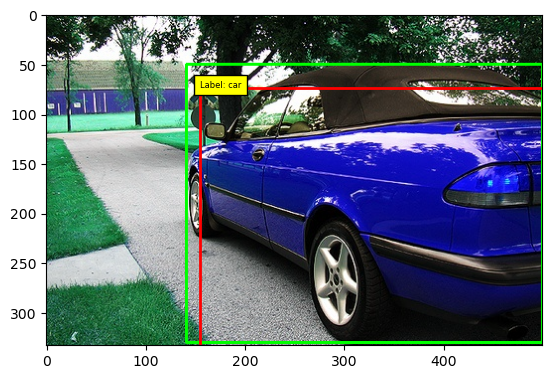

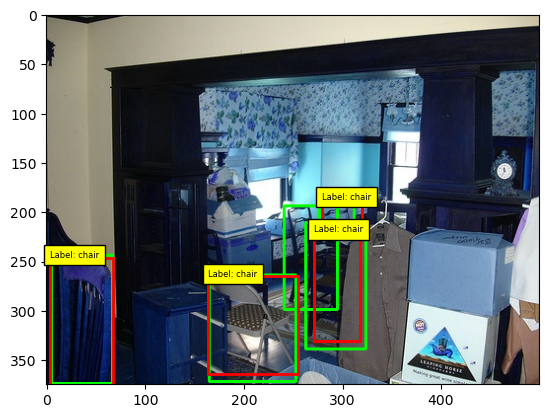

In [294]:
# Image 1
sample_img_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/JPEGimages/000007.jpg'
sample_anno_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000007.xml'
sample_w_boxes = draw_gtbboxes(sample_img_path, sample_anno_path)

bboxes = bbox_train_dataset[1][1]["boxes"]
labels = bbox_train_dataset[1][1]["labels"]
# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(sample_w_boxes)

# Draw bounding boxes
for i, bbox in enumerate(bboxes):
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, f"Label: {VOC_CLASSES[labels[i]]}", fontsize=6, bbox=dict(facecolor='yellow', alpha=1))


# Image 2
sample_img_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/JPEGimages/000005.jpg'
sample_anno_path = '/Users/h383kim/pytorch/data/PASCAL_VOC_trainval/VOCdevkit/VOC2007/Annotations/000005.xml'
sample_w_boxes = draw_gtbboxes(sample_img_path, sample_anno_path)

bboxes = bbox_train_dataset[0][1]["boxes"]
labels = bbox_train_dataset[0][1]["labels"]
# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(sample_w_boxes)

# Draw bounding boxes
for i, bbox in enumerate(bboxes):
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, f"Label: {VOC_CLASSES[labels[i]]}", fontsize=6, bbox=dict(facecolor='yellow', alpha=1))

In [ ]:
#bbox_regressors = train_BBoxRegressors(feature_extractor, bbox_train_loader, optimizer)

In [285]:
import time
import copy

def train_regressors(model: torch.nn.Module, 
                     train_dataloader: torch.utils.data.DataLoader, 
                     optimizer: torch.optim.Optimizer,
                     loss_fn: torch.nn.Module=RidgeRegressionLoss(),
                     num_epochs: int=10):
    best_loss = 10000
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        # Train the model and print save the results
        train_loss = train_BBoxRegressors(feature_extractor=model,
                                          dataloader=train_dataloader,
                                          optimizer=optimizer,
                                          loss_fn=loss_fn)
        
        if train_loss < best_loss:
            best_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
        end_time = time.time()
        time_elapsed = end_time - start_time
        print(f"------------ epoch {epoch} ------------")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Time taken: {time_elapsed / 60:.0f}min {time_elapsed % 60:.0f}s")
        
    model.load_state_dict(best_model_wts)
    return model 

In [286]:
Bbox_Regressors = train_regressors(feature_extractor, bbox_train_loader, optimizer)

Number of proposals seen: 531
------------ epoch 1 ------------
Train loss: 23.7253
Time taken: 10min 43s
Number of proposals seen: 531
------------ epoch 2 ------------
Train loss: 23.6613
Time taken: 10min 34s
Number of proposals seen: 531
------------ epoch 3 ------------
Train loss: 23.7040
Time taken: 10min 36s
Number of proposals seen: 531
------------ epoch 4 ------------
Train loss: 23.7431
Time taken: 10min 37s
Number of proposals seen: 531
------------ epoch 5 ------------
Train loss: 23.7166
Time taken: 10min 37s


KeyboardInterrupt: 

In [ ]:
torch.save(Bbox_Regressors.state_dict(), 'trained_bbox_regressors.pth')

# Inference Function

In [34]:
from torchvision.ops import nms

def transform_proposal(img):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Resize to 227x227
        transforms.ToTensor(),  # Convert back to tensor
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    return transform(img)

def infer(img_path):
    img = Image.open(img_path)
    
    # Step 1: Generate Region Proposals
    proposals = selective_search.selective_search(img_path)

    # Step 2: Extract features from the proposals
    features = []
    with torch.no_grad():
        for i in range(len(proposals)):
            x_min, y_min, x_max, y_max = proposals[i]
            cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max-y_min).item(), width=(x_max-x_min).item())
            transformed_img = transform_proposal(cropped_img).to(DEVICE).unsqueeze(0)
            
            feature_vector = feature_extractor(transformed_img).squeeze(0).cpu().numpy()
            features.append(feature_vector)

    features = np.array(features)

    # Step 3: Classify proposals
    scores = []
    for cls_id, svm_classifier in svm_classifiers.items():
        class_scores = svm_classifier.decision_function(features) # Shape: [len(proposals)]
        scores.append(class_scores)
    scores = np.array(scores) # Shape: [len(classes), len(proposals)]
    predicted_labels = np.argmax(scores, axis=0) # Shape: [len(proposals)]
    #confidence_scores = [scores[cls][idx] for idx,cls in enumerate(predicted_labels)]
    #confidence_scores = np.array(confidence_scores)
    confidence_scores, _ = torch.max(torch.tensor(scores), dim=0) # Confidence_score Shape: [len(proposals)]
    
    # Step 4: Apply NMS to filter overlapping bounding boxes
    proposals = torch.tensor(proposals, dtype=torch.float32)
    confidence_scores = torch.tensor(confidence_scores, dtype=torch.float32)
    kept_indices = nms(proposals, confidence_scores, 0.5)
    
    final_proposals = proposals[kept_indices]
    final_scores = confidence_scores[kept_indices]
    final_labels = torch.tensor(predicted_labels)[kept_indices]

    # (Optional) Further filtering
    final_keep_indices = final_scores > 5.0
    final_proposals = final_proposals[final_keep_indices]
    final_scores = final_scores[final_keep_indices]
    final_labels = final_labels[final_keep_indices]
    
    return final_proposals, final_scores, final_labels

In [42]:
from torchvision.ops import nms

def transform_proposal(img):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Resize to 227x227
        transforms.ToTensor(),  # Convert back to tensor
        transforms.ConvertImageDtype(torch.float32),
    ])
    
    return transform(img)

def infer(img_path):
    img = Image.open(img_path)
    
    # Step 1: Generate Region Proposals
    proposals = selective_search.selective_search(img_path)

    # Step 2: Extract features from the proposals
    features = []
    with torch.no_grad():
        for i in range(len(proposals)):
            x_min, y_min, x_max, y_max = proposals[i]
            cropped_img = crop(img, top=y_min.item(), left=x_min.item(), height=(y_max-y_min).item(), width=(x_max-x_min).item())
            transformed_img = transform_proposal(cropped_img).to(DEVICE).unsqueeze(0)
            
            feature_vector = feature_extractor(transformed_img).squeeze(0).cpu().numpy()
            features.append(feature_vector)

    features = np.array(features)

    # Step 3: Classify proposals
    scores = []
    for cls_id, svm_classifier in svm_classifiers.items():
        class_scores = svm_classifier.decision_function(features) # Shape: [len(proposals)]
        scores.append(class_scores)
    scores = np.array(scores) # Shape: [len(classes), len(proposals)]
    predicted_labels = np.argmax(scores, axis=0) # Shape: [len(proposals)]
    confidence_scores, _ = torch.max(torch.tensor(scores), dim=0) # Confidence_score Shape: [len(proposals)]
    
    # Step 4: Apply NMS to filter overlapping bounding boxes
    proposals = torch.tensor(proposals, dtype=torch.float32)
    # confidence_scores = torch.tensor(confidence_scores, dtype=torch.float32)
    # kept_indices = nms(proposals, confidence_scores, 0.1)

    final_proposals = []
    final_scores = []
    final_labels = []
    
    # Apply NMS for each class separately
    for class_id in range(20):
        class_scores = scores[class_id]
        # Filter out boxes with non-positive scores
        keep_indices = class_scores > 0

        if keep_indices.sum() == 0:
            continue  # No boxes for this class

        filtered_proposals = torch.tensor(proposals[keep_indices], dtype=torch.float32)
        filtered_scores = torch.tensor(class_scores[keep_indices], dtype=torch.float32)

        # Apply NMS for the current class
        kept_indices = nms(filtered_proposals, filtered_scores, 0.5)

        # Store the results
        final_proposals.append(filtered_proposals[kept_indices])
        final_scores.append(filtered_scores[kept_indices])
        final_labels.extend([class_id] * len(kept_indices))  # Add class label for each kept box
    

    # (Optional) Further filtering
    final_keep_indices = final_scores > 5.0
    final_proposals = final_proposals[final_keep_indices]
    final_scores = final_scores[final_keep_indices]
    final_labels = final_labels[final_keep_indices]
    
    return final_proposals, final_scores, final_labels

In [43]:
#proposals, final_scores, final_labels = infer(IMG_LIST[0])
proposals2, final_scores2, final_labels2 = infer(IMG_LIST[0])

/var/folders/n0/q19jqn7s6ts2t70bq5v6mhhc0000gn/T/ipykernel_6794/995967957.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered_proposals = torch.tensor(proposals[keep_indices], dtype=torch.float32)


TypeError: '>' not supported between instances of 'list' and 'float'

In [38]:
proposals, final_scores, final_labels

([tensor([[347., 319., 375., 375.],
          [107., 188., 328., 375.],
          [320., 187., 369., 222.],
          [  0.,   0.,  93.,  17.],
          [150.,  56., 473., 289.],
          [121., 283., 344., 375.],
          [159., 131., 344., 320.]]),
  tensor([[224., 194., 270., 223.],
          [433., 136., 477., 171.],
          [337.,  86., 365., 119.],
          [221.,  82., 254.,  94.],
          [271., 202., 365., 331.],
          [ 24., 269.,  63., 375.]]),
  tensor([[236.,  25., 344.,  37.],
          [161.,  74., 199.,  90.],
          [267., 350., 328., 375.],
          [483., 306., 500., 321.],
          [273., 223., 319., 244.],
          [183., 322., 209., 351.],
          [156.,  76., 173., 120.],
          [275., 211., 342., 239.],
          [256., 290., 298., 329.],
          [368.,  63., 382.,  92.],
          [159.,  70., 215.,  96.],
          [220., 316., 246., 357.],
          [  0., 197.,  31., 232.],
          [172., 153., 195., 174.],
          [343., 314., 3

In [39]:
len(final_scores)

19

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

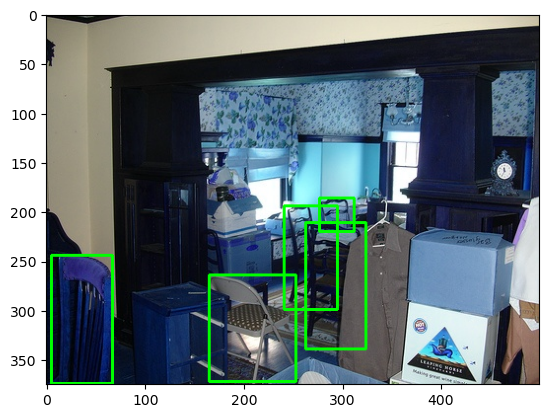

In [40]:
sample_w_boxes = draw_gtbboxes(IMG_LIST[0], ANNO_LIST[0])
fig, ax = plt.subplots(1)
ax.imshow(sample_w_boxes)

# Draw bounding boxes
for bbox in proposals:
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [119]:
proposals2, final_scores2, final_labels2

(tensor([[366., 349., 438., 375.],
         [465., 186., 500., 375.],
         [ 17., 245.,  68., 307.],
         [336., 154., 353., 213.],
         [339., 116., 365., 218.],
         [159., 149., 170., 188.],
         [  0., 194.,  71., 372.],
         [163., 180., 179., 208.],
         [ 96., 165., 191., 278.],
         [252., 210., 308., 341.],
         [433., 136., 477., 171.]]),
 tensor([7.9047, 7.5181, 6.3480, 6.3206, 5.8292, 5.7368, 5.5115, 5.5108, 5.4605,
         5.3250, 5.1302]),
 tensor([14, 14,  8, 14, 14, 14,  8, 14, 14,  8, 14]))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

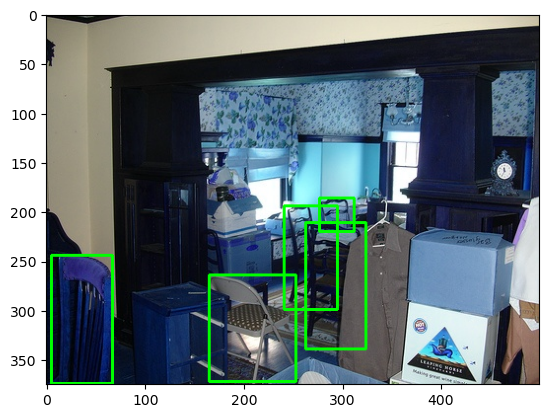

In [44]:
sample_w_boxes = draw_gtbboxes(IMG_LIST[0], ANNO_LIST[0])
fig, ax = plt.subplots(1)
ax.imshow(sample_w_boxes)

# Draw bounding boxes
for idx, bbox in enumerate(proposals):
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, f"{VOC_CLASSES[final_labels[idx]]} : {final_scores[idx]:.2f}", fontsize=8, bbox=dict(facecolor='yellow', alpha=1))

In [124]:
final_scores2

tensor([7.9047, 7.5181, 6.3480, 6.3206, 5.8292, 5.7368, 5.5115, 5.5108, 5.4605,
        5.3250, 5.1302])

In [ ]:
torch.save(Bbox_Regressors.state_dict(), 'bounding_box_regressors.pth')

In [123]:
interpret(final_labels2)

['person',
 'person',
 'chair',
 'person',
 'person',
 'person',
 'chair',
 'person',
 'person',
 'chair',
 'person']